### 2.导入相关库

In [1]:
import os
import jieba
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from d2l import torch as d2l

### 3. 数据加载

In [2]:
train_data = pd.read_csv('data/train.tsv', sep='\t')
valid_data = pd.read_csv('data/dev.tsv', sep='\t')
test_data = pd.read_csv('data/test.tsv', sep='\t') 
x_train, y_train = train_data.text_a.values, train_data.label.values # 训练集
x_valid, y_valid = valid_data.text_a.values, valid_data.label.values # 验证集
x_test, y_test = test_data.text_a.values, test_data.label.values # 测试集

In [3]:
train_data

,label,text_a
0,1,选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全...
1,1,15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很...
2,0,房间太小。其他的都一般。。。。。。。。。
3,0,"1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸..."
4,1,"今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量..."
...,...,...
9141,1,看过该书，感觉中医暂时不会消亡，尚有一、二十株老树活着，还有毛以林、黄煌、刘力红等一批有一定...
9142,0,这本书没读到底，不是特别喜欢。完全可以用序中的评价来表达我的感受：可以包容，却不想实践。除了...
9143,1,"虽是观景房,不过我住的楼层太低(19楼)看不到江景,但地点很好,离轻轨临江门站和较场口站(起..."
9144,1,性价比不错，交通方便。行政楼层感觉很好，只是早上8点楼上装修，好吵。 中餐厅档次太低，虽然便...


In [4]:
x_train, y_train

(array(['选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般',
        '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错',
        '房间太小。其他的都一般。。。。。。。。。', ...,
        '虽是观景房,不过我住的楼层太低(19楼)看不到江景,但地点很好,离轻轨临江门站和较场口站(起点)很近,解放碑就在附近(大约100多公尺吧)!',
        '性价比不错，交通方便。行政楼层感觉很好，只是早上8点楼上装修，好吵。 中餐厅档次太低，虽然便宜，但是和酒店档次不相配。',
        '跟心灵鸡汤没什么本质区别嘛，至少我不喜欢这样读经典，把经典都解读成这样有点去中国化的味道了'], dtype=object),
 array([1, 1, 0, ..., 1, 1, 0]))

### 4. 构建词汇表

In [5]:
vocab = set()
cut_docs = train_data.text_a.apply(lambda x: jieba.cut(x)).values
for doc in cut_docs:
    for word in doc:
        if word.strip():
            vocab.add(word.strip())

# 将词表写入本地vocab.txt文件
with open('data/vocab.txt', 'w') as file:
    for word in  vocab:
        file.write(word)
        file.write('\n')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.868 seconds.
Prefix dict has been built successfully.


In [6]:
len(vocab)

35091

In [7]:
list(vocab)[:10]

['妥善', '金刚经', '落花', '品牌机', '微观', '面有', '最高级', '能', '2878108', '难负']

### 5. 定义配置参数

In [8]:
class Config():
    def __init__(self, version):
        assert version in ['S', 'M', 'L', 'XL'], 'version must be one of "S", "M", "L", "XL"'
        self.version = version
        if version == 'S':
            self.embedding_dim = 4
        elif version == 'M':
            self.embedding_dim = 10
        elif version == 'L':
            self.embedding_dim = 50
        elif version == 'XL':
            self.embedding_dim = 100
        self.max_seq_len = 200
        self.conv_out_channels = 128
        self.linear_hidden_size = 128
        if version in ['XL', 'L']:
            self.kernel_sizes = [2, 3, 4, 5]
        elif version == 'M':
            self.kernel_sizes = [2, 3, 4]
        elif version == 'S':
            self.kernel_sizes = [2, 3]
        self.dropout = 0.5
        self.vocab_file = 'data/vocab.txt'

选择对应的模型类别

In [9]:
# 根据模型大小实例化一个配置类
config = Config('S')

### 6. 定义预处理类

In [10]:
class Preprocessor():
    def __init__(self, config):
        self.config = config
        # 初始化词和id的映射词典，预留0给padding字符，1给词表中未见过的词
        token2idx = {"[PAD]": 0, "[UNK]": 1} # {word：id}
        with open(config.vocab_file, 'r') as reader:
            for index, line in enumerate(reader):
                token = line.strip()
                token2idx[token] = index+2
        self.token2idx = token2idx
        
    def transform(self, text_list):
        # 文本分词，并将词转换成相应的id
        idx_list = [[self.token2idx.get(word.strip(), self.token2idx['[UNK]']) for word in jieba.cut(text)] for text in text_list]
        # 对不同长度的文本padding长统一长度，后面补0
        idx_padding = np.zeros((len(idx_list), self.config.max_seq_len))
        for i, idx in enumerate(idx_list):
            idx_padding[i, :len(idx)] = idx[:self.config.max_seq_len]
        return np.int32(idx_padding)

In [11]:
preprocessor = Preprocessor(config)
preprocessor.transform(['性价比不错，交通方便。', '房间太小。其他的都一般。'])

array([[22727, 32934, 27450, 25436, 13169, 13635,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

### 7. 定义模型类

In [12]:
class TextCNN(nn.Module):
    def __init__(self, config, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.config = config
        self.preprocessor = Preprocessor(config)

        # 词嵌入层
        self.embedding = nn.Embedding(len(self.preprocessor.token2idx), self.config.embedding_dim)
        # 卷积层
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=self.config.embedding_dim, out_channels=self.config.conv_out_channels, kernel_size=k) for k in config.kernel_sizes])
        self.pool = nn.ModuleList([nn.AdaptiveMaxPool1d(1) for _ in config.kernel_sizes])
        self.dropout = nn.Dropout(self.preprocessor.config.dropout)
        # 全连接层
        self.fc1 = nn.Linear(self.config.conv_out_channels * len(config.kernel_sizes), self.config.linear_hidden_size)
        self.fc2 = nn.Linear(self.config.linear_hidden_size, 2)
    
    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x) # [batch_size, seq_len, embedding_dim]
        x = x.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [pool(i).squeeze(dim=-1) for i, pool in zip(x, self.pool)]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [13]:
model = TextCNN(config)
model

TextCNN(
  (embedding): Embedding(35093, 4)
  (conv): ModuleList(
    (0): Conv1d(4, 128, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 128, kernel_size=(3,), stride=(1,))
  )
  (pool): ModuleList(
    (0-1): 2 x AdaptiveMaxPool1d(output_size=1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [14]:
x = torch.randint(0, len(preprocessor.token2idx), (8, 200))
y = model(x)
y

tensor([[0.4458, 0.5542],
        [0.5020, 0.4980],
        [0.7448, 0.2552],
        [0.6903, 0.3097],
        [0.6220, 0.3780],
        [0.7404, 0.2596],
        [0.5639, 0.4361],
        [0.7594, 0.2406]], grad_fn=<SoftmaxBackward0>)

### 8. 启动训练

In [15]:
batch_size = 128
num_epochs = 50
lr = 0.001

In [16]:
# 通过config.transform，并转换成torch.Tensor
x_train = preprocessor.transform(x_train)
x_valid = preprocessor.transform(x_valid)
x_test = preprocessor.transform(x_test)

# 定义训练迭代器
train_iter = DataLoader(list(zip(x_train, y_train)), shuffle=True, batch_size=batch_size)
valid_iter = DataLoader(list(zip(x_valid, y_valid)), shuffle=False, batch_size=1)
test_iter = DataLoader(list(zip(x_test, y_test)), shuffle=False, batch_size=1)

for x, y in train_iter:
    print(x)
    print(y)
    break

tensor([[ 4677, 11453, 24878,  ...,     0,     0,     0],
        [23139, 31201, 27812,  ...,     0,     0,     0],
        [26054, 29797,  2696,  ...,     0,     0,     0],
        ...,
        [  472, 21948, 35062,  ...,     0,     0,     0],
        [22727, 23877, 27450,  ...,     0,     0,     0],
        [ 3068, 34984, 27450,  ...,     0,     0,     0]], dtype=torch.int32)
tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1])


输出模型参数量

In [17]:
for name, layer in model.named_modules():
    print(name, end=': ')
    print(sum(param.numel() for param in layer.parameters()))

: 176342
embedding: 140372
conv: 2816
conv.0: 1152
conv.1: 1664
pool: 0
pool.0: 0
pool.1: 0
dropout: 0
fc1: 32896
fc2: 258


借助d2l进行训练

In [18]:
def train(net, train_iter, valid_iter, num_epochs, lr, loss, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    # loss = nn.CrossEntropyLoss()
    # loss = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

如果想要使用已经训练的模型，则不运行下面这个单元格就好

loss 0.384, train acc 0.927, valid acc 0.828
40539.6 examples/sec on cuda:0


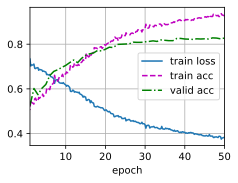

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
train(model, train_iter, valid_iter, num_epochs, lr, loss, d2l.try_gpu())
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
torch.save(model.state_dict(), 'checkpoints/TextCNN-'+config.version+'.pt')

如果想要加载模型，运行下面这个单元格就好

In [20]:
# model = TextCNN(config)
# 加载模型信息
model.load_state_dict(torch.load('checkpoints/TextCNN-'+config.version+'.pt'))
model.to(d2l.try_gpu())

TextCNN(
  (embedding): Embedding(35093, 4)
  (conv): ModuleList(
    (0): Conv1d(4, 128, kernel_size=(2,), stride=(1,))
    (1): Conv1d(4, 128, kernel_size=(3,), stride=(1,))
  )
  (pool): ModuleList(
    (0-1): 2 x AdaptiveMaxPool1d(output_size=1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

### 9. 进行评估

In [21]:
# 评估测试集准确率
d2l.evaluate_accuracy_gpu(model, test_iter, d2l.try_gpu())

0.8525

In [22]:
text = ['性价比不错，交通方便。', '房间太小。其他的都一般。']
text = preprocessor.transform(text)
text = torch.tensor(text, dtype=torch.int32).to(d2l.try_gpu())
pred = model(text)
for i in range(len(text)):
    print('负面' if pred[i].argmax().item() == 0 else '正面')

正面
负面
